In [ ]:
# annotation과 image 디렉토리 설정. annotation디렉토리에 있는 파일 확인. 
import os
from pathlib import Path

HOME_DIR = str(Path.home())

ANNO_DIR = os.path.join(HOME_DIR, 'DLCV/data/Dog/annotation')
IMAGE_DIR = os.path.join(HOME_DIR, 'DLCV/data/Dog/images')
print(ANNO_DIR)

files = os.listdir(ANNO_DIR)
print('파일 개수는:',len(files))
print(files)

In [2]:
import glob
import xml.etree.ElementTree as ET

classes_map = {'Dog':0}

def xml_to_csv(path, output_filename):
    xml_list = []
    # xml 확장자를 가진 모든 파일의 절대 경로로 xml_file할당. 
    with open(output_filename, "w") as train_csv_file:
        for xml_file in glob.glob(path + '/*.xml'):
            # xml 파일을 parsing하여 XML Element형태의 Element Tree를 생성하여 object 정보를 추출. 
            tree = ET.parse(xml_file)
            root = tree.getroot()
            # 파일내에 있는 모든 object Element를 찾음. 
            full_image_name = os.path.join(IMAGE_DIR, root.find('filename').text)
            value_str_list = ' '
            for obj in root.findall('object'):
                xmlbox = obj.find('bndbox')
                class_name = obj.find('name').text
                x1 = int(xmlbox.find('xmin').text)
                y1 = int(xmlbox.find('ymin').text)
                x2 = int(xmlbox.find('xmax').text)
                y2 = int(xmlbox.find('ymax').text)
                # 
                class_id = classes_map[class_name]
                value_str = ('{0},{1},{2},{3},{4}').format(x1, y1, x2, y2, class_id)
                # object별 정보를 tuple형태로 object_list에 저장. 
                value_str_list = value_str_list+value_str+' '
        
            train_csv_file.write(full_image_name+' '+ value_str_list+'\n')
        # xml file 찾는 for loop 종료 

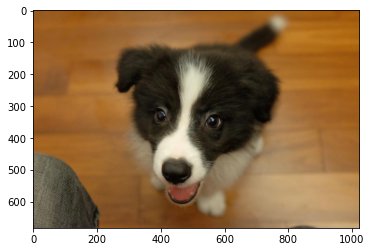

In [4]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cv2.cvtColor(cv2.imread('/home/dsl001/DLCV/data/Dog/images/f54103c441eb38bf.jpg'), cv2.COLOR_BGR2RGB))

In [2]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [3]:
import sys, os

LOCAL_PACKAGE_DIR = os.path.abspath("./keras-yolo3")
sys.path.append(LOCAL_PACKAGE_DIR)

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

In [8]:
from train import get_classes, get_anchors
from train import create_model, data_generator, data_generator_wrapper

BASE_DIR = os.path.join(HOME_DIR, 'DLCV/Detection/yolo/keras-yolo3')

## 학습을 위한 기반 환경 설정. annotation 파일 위치, epochs시 저장된 모델 파일, Object클래스 파일, anchor 파일.
annotation_path = os.path.join(ANNO_DIR, 'Dog_annotation.csv')
log_dir = os.path.join(BASE_DIR, 'snapshots/Dog/')
classes_path = os.path.join(BASE_DIR, 'model_data/Dog_classes.txt')
anchors_path = os.path.join(BASE_DIR,'model_data/yolo_anchors.txt')

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
print(class_names, num_classes)
print(anchors)

['Dog'] 1
[[ 10.  13.]
 [ 16.  30.]
 [ 33.  23.]
 [ 30.  61.]
 [ 62.  45.]
 [ 59. 119.]
 [116.  90.]
 [156. 198.]
 [373. 326.]]


#### yolo 모델 학습을 위한 전반적인 파라미터를 config 클래스로 설정하고 필요시 이를 수정하여 학습. 

In [16]:
# csv annotation 파일을 읽어서 lines 리스트로 만듬. 
with open(annotation_path) as f:
    lines = f.readlines()

class config:
    #tiny yolo로 모델로 초기 weight 학습 원할 시 아래를 tiny-yolo.h5로 수정. 
    initial_weights_path=os.path.join(BASE_DIR, 'snapshots/Dog_detection/ep969-loss15.139-val_loss14.382.h5' )
    # input_shape는 고정. 
    input_shape=(416, 416)
    # epochs는 freeze, unfreeze 2 step에 따라 설정. 
    first_epochs=10
    first_initial_epochs=0
    second_epochs=10000
    second_initial_epochs=10
    # 학습시 batch size, train,valid건수, epoch steps 횟수  
    batch_size = 16
    val_split = 0.1   
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val
    train_epoch_steps = num_train//batch_size 
    val_epoch_steps =  num_val//batch_size
    
    anchors = get_anchors(anchors_path)
    class_names = get_classes(classes_path)
    num_classes = len(class_names)
    # epoch시 저장된 weight 파일 디렉토리 
    log_dir = os.path.join(BASE_DIR, 'snapshots/Dog_detection/')
    
print('Class name:', config.class_names,'\nNum classes:', config.num_classes)

Class name: ['Dog'] 
Num classes: 1


#### csv 파일을 입력 받아서 train 데이터와 valid 데이터 처리를 위한 data_generator_wrapper객체를 각각 생성.
* train용, valid 용 data_generator_wrapper는 Yolo 모델의 fit_generator()학습시 인자로 입력됨. 

In [10]:
def data_generator_default(annotation_lines, batch_size, input_shape, anchors, num_classes, random):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=random)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

In [11]:
def data_generator_wrapper_default(annotation_lines, batch_size, input_shape, anchors, num_classes, random):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator_default(annotation_lines, batch_size, input_shape, anchors, num_classes, random)

In [12]:
def create_generator(lines):
    
    train_data_generator = data_generator_wrapper_default(lines[:config.num_train], config.batch_size, 
                                                  config.input_shape, config.anchors, config.num_classes, random=100)
    
    valid_data_generator = data_generator_wrapper_default(lines[config.num_train:], config.batch_size, 
                                                  config.input_shape, config.anchors, config.num_classes, random=100)
    
    return train_data_generator, valid_data_generator

#### YOLO 모델 또는 tiny yolo 모델 반환. 초기 weight값은 pretrained된 yolo weight값으로 할당. 

In [13]:
# anchor 개수에 따라 tiny yolo 모델 또는 yolo 모델 반환. 
def create_yolo_model():
    is_tiny_version = len(config.anchors)==6 
    if is_tiny_version:
        model = create_tiny_model(config.input_shape, config.anchors, config.num_classes, 
            freeze_body=2, weights_path=config.initial_weights_path)
    else:
        model = create_model(config.input_shape, config.anchors, config.num_classes, 
            freeze_body=2, weights_path=config.initial_weights_path)
        
    return model 

#### callback 객체들을 생성. 

In [14]:
# Tensorboard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping callback 반환
def create_callbacks():
    logging = TensorBoard(log_dir=config.log_dir)
    checkpoint = ModelCheckpoint(config.log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1)
    
    #개별 callback들을 한꺼번에 list로 묶어서 반환
    return [logging, checkpoint, reduce_lr, early_stopping]

#### 학습 수행

In [ ]:
# create_generator(), create_model(), create_callbacks() 수행. 
# from keras.utils import multi_gpu_model

train_data_generator, valid_data_generator = create_generator(lines)
dog_model = create_yolo_model()
callbacks_list = create_callbacks()

# 최초 모델은 주요 layer가 freeze되어 있음. 안정적인 loss를 확보하기 위해 주요 layer를 freeze한 상태로 먼저 학습. 
print('First train 시작')
dog_model.compile(optimizer=Adam(lr=1e-3), loss={'yolo_loss': lambda y_true, y_pred: y_pred})
dog_model.fit_generator(train_data_generator, steps_per_epoch=config.train_epoch_steps,
                        validation_data=valid_data_generator, validation_steps=config.val_epoch_steps,
                        epochs=config.first_epochs, initial_epoch=config.first_initial_epochs, 
                        callbacks=callbacks_list)

# 1단계 학습 완료 모델 저장. 
dog_model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# 모든 layer를 trainable=True로 설정하고 학습 수행. 
for i in range(len(dog_model.layers)):
    dog_model.layers[i].trainable = True
    
print('Second train 시작' )

# Tensorboard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping callback 반환
def create_callbacks():
    logging = TensorBoard(log_dir=config.log_dir)
    checkpoint = ModelCheckpoint(config.log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=300, verbose=1)
    
    #개별 callback들을 한꺼번에 list로 묶어서 반환
    return [logging, checkpoint, reduce_lr]

callbacks_list = create_callbacks()
dog_model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) 
dog_model.fit_generator(train_data_generator, steps_per_epoch=config.train_epoch_steps,
                        validation_data=valid_data_generator, validation_steps=config.val_epoch_steps,
                        epochs=config.second_epochs, initial_epoch=config.second_initial_epochs,
                        callbacks=callbacks_list)

# 최종 학습 완료 모델 저장. 
dog_model.save_weights(log_dir + 'trained_weights_final.h5')

#### 최종 학습된 모델을 로딩하여 Object Detection 수행. 

In [4]:
from yolo import YOLO
#keras-yolo에서 image처리를 주요 PIL로 수행. 
from PIL import Image

LOCAL_PACKAGE_DIR = os.path.abspath("./keras-yolo3")
sys.path.append(LOCAL_PACKAGE_DIR)

# dog_yolo = YOLO(model_path='/home/dsl001/DLCV/Detection/yolo/keras-yolo3/snapshots/Dog/trained_weights_final.h5',
#                 anchors_path='~/DLCV/Detection/yolo/keras-yolo3/model_data/yolo_anchors.txt',
#                 classes_path='~/DLCV/Detection/yolo/keras-yolo3/model_data/Dog_classes.txt')

dog_yolo = YOLO(model_path='/home/dsl001/DLCV/Detection/yolo/keras-yolo3/snapshots/Dog_detection/ep432-loss5.571-val_loss6.285.h5',
                anchors_path='~/DLCV/Detection/yolo/keras-yolo3/model_data/yolo_anchors.txt',
                classes_path='~/DLCV/Detection/yolo/keras-yolo3/model_data/Dog_classes.txt')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
/home/dsl001/DLCV/Detection/yolo/keras-yolo3/snapshots/Dog_detection/ep432-loss5.571-val_loss6.285.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### 이미지 Object Detection

(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (135, 16) (492, 333)
0.056124174036085606
[['Dog 1.00', (135, 16), (492, 333)]]


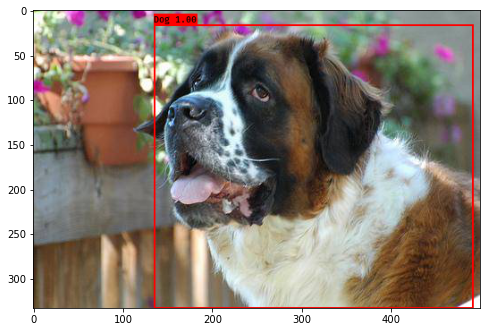

In [5]:
img = Image.open('/home/dsl001/DLCV/data/Dog_images/images/Dog_162.jpg')
detected_img, info = dog_yolo.detect_image(img)
print(info)
plt.figure(figsize=(8, 8))
plt.imshow(detected_img)

(416, 416, 3)
Found 1 boxes for img
Dog 1.00 (7, 57) (299, 300)
0.05026975111104548
[['Dog 1.00', (7, 57), (299, 300)]]


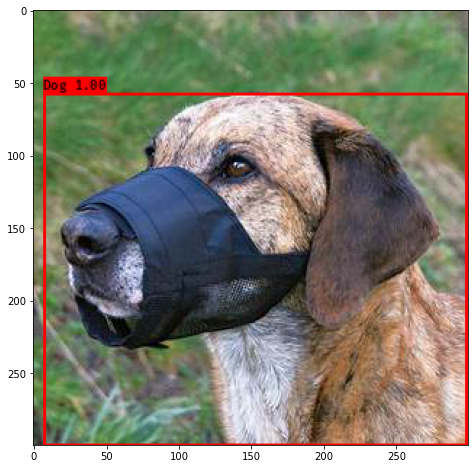

In [47]:
img = Image.open('/home/dsl001/DLCV/data/Dog_images/images/Muzzle_400.jpg')
detected_img, info = dog_yolo.detect_image(img)
print(info)
plt.figure(figsize=(8, 8))
plt.imshow(detected_img)

In [14]:
import numpy as np

In [42]:
for data in info:
    label = data[0]
    rigth_top = data[1]
    left_bottom = data[2]
    
print(label, rigth_top, left_bottom)

Dog 0.32 (9, 505) (335, 824)


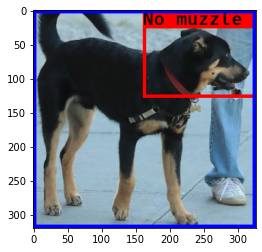

In [43]:
data = np.array(img)
plt.imshow(data[rigth_top[1]:left_bottom[1]+1, rigth_top[0]:left_bottom[0]+1, :])

#### 영상 Object Detection 

In [5]:
import cv2
import time

def detect_video_yolo(model, input_path, output_path=""):
    
    start = time.time()
    cap = cv2.VideoCapture(input_path)
    
    #codec = cv2.VideoWriter_fourcc(*'DIVX')
    codec = cv2.VideoWriter_fourcc(*'XVID')
    vid_fps = cap.get(cv2.CAP_PROP_FPS)
    vid_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
    
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, '원본 영상 FPS:',vid_fps, '원본 Frame 크기:', vid_size)
    index = 0
    while True:
        hasFrame, image_frame = cap.read()
        if not hasFrame:
            print('프레임이 없거나 종료 되었습니다.')
            break
        start = time.time()
        # PIL Package를 내부에서 사용하므로 cv2에서 읽은 image_frame array를 다시 PIL의 Image형태로 변환해야 함.  
        image = Image.fromarray(image_frame)
        # 아래는 인자로 입력된 yolo객체의 detect_image()로 변환한다.
        detected_image, info = model.detect_image(image)
        # cv2의 video writer로 출력하기 위해 다시 PIL의 Image형태를 array형태로 변환 
        result = np.asarray(detected_image)
        index +=1
        print('#### frame:{0} 이미지 처리시간:{1}'.format(index, round(time.time()-start,3)))
        
        vid_writer.write(result)
    
    vid_writer.release()
    cap.release()
    print('### Video Detect 총 수행시간:', round(time.time()-start, 5))

In [ ]:
detect_video_yolo(dog_yolo, '../../data/video/설명.mp4', '../../data/output/설명.avi')
!gsutil cp ../../data/output/NFL_yolo_01.avi gs://my_bucket_dlcv/data/output/NFL_yolo_01.avi